In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
pi = math.pi

In [2]:
rcut = 3.0  ##### Cut-off distance. If distance between atoms is greater than this, interaction between them is ignored.
rcutsquare = rcut**2
g2 = 1./rcutsquare
g6 = g2*g2*g2
potcut = 4.*g6*(g6-1) ##### Term to be subtracted from pair potential energy

In [3]:
##### Function to compute acceleration for a pair of atoms. r12 is relative displacement of atoms.

def acceleration(r12): 
    r12square = np.dot(r12,r12)
    f2 = 1./r12square #1/r^2
    f6 = f2*f2*f2 #1/r^6
    acc = 48.*f2*f6*(f6-0.5)*r12
    return acc


In [4]:
#### Function to compute potential energy for the system of particles. `pos' is the array of position vectors.
def potentialenergy(pos):
    potential = 0.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j] ## Relative position vector of the pair
            for l in range(2):  ### Calculating the correct separation between particles because of periodic boundary conditions.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            rijsquare = np.dot(rij,rij)
            if rijsquare < rcutsquare: # Imposing interaction cut-off
                f2 = 1./rijsquare
                f6 = f2*f2*f2
                potential += 4.*f6*(f6-1.) - potcut
    return potential

In [79]:
number = 5
Natoms = number**2  # No. of atoms
Ratom = 0.5  ### Radius of atom used to illustrate the atom as a sphere.
rho = 0.25 ### Number Density
L = math.pow(Natoms/rho,0.5) # Length of a side of the square containing the gas.
T0 = 120. # Natural temperture scale, T0 = epsilon/k.
# Temp = 0.01 #dimensionless temperature
T = 2.5  # Temperature in Kelvin
dt = 1e-2  # Time step for Verlet Algorithm
#

In [80]:
###### Atoms are arranged initially in a square lattice configuration with spacing between neighbors equal to equilibrium separation of the potential energy.

equilib_sep = math.pow(2.,1./6.)  ## Equilibrium separation of atoms r_0 = 2^{1/6}
wall_spacing = (L-(number-1)*equilib_sep)/2.  ## Distance betwee the walls and the initial array of atoms.
poslist = []  # List for positions of atoms
vlist = []   # List for velocities

################  Initialize positions and velocities ##############################################
x, y = wall_spacing, wall_spacing

for i in range(number):
    for j in range(number):
        xi, yi = x + equilib_sep*j, y + equilib_sep*i
        poslist.append((xi,yi))


####### Initially, all particles have the same speed but random velocity directions. ################
v0 = math.sqrt(2.*T/T0)

for i in range(Natoms):
    phi = 2*np.pi*np.random.random()
    vx = v0*np.cos(phi)
    vy = v0*np.sin(phi)
    vlist.append((vx,vy))
###################################################################################################

pos = np.array(poslist)  ### Converts lists to numpy arrays
v = np.array(vlist) ## Scaled velocity


V_cm = np.sum(v, axis = 0)/Natoms ## Correcting for CM velocity.
V = np.array([V_cm,]*Natoms)
v -= V  


In [81]:
delta = 0.1 #bin size
no_of_shells = int(0.5*L/delta)

#RDF function
def rdf(pair_distance, no_of_shells=no_of_shells):
    r_array = np.zeros(no_of_shells)
    which_bin = int(pair_distance/delta)
    if which_bin<=no_of_shells-1:
        bin_array[which_bin] += 1
    for i in range(1,int(no_of_shells)):
        r_array[i] = bin_array[i]/(2*rho*pi*i*delta*delta)
    
    return r_array  

In [82]:
t_initial = 0. # Initial time.
t_final = 100. # Time upto which simulation is carried out.
rdf_data = []
dist_array = np.zeros(no_of_shells)
time = t_initial
pair_distance_record = []
counter = 0
bin_array = np.zeros(no_of_shells)

# potential_energy = potentialenergy(pos)
kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))
# energy = kinetic_energy + potential_energy
Time_List = [time]
# Energy_List = [energy]
# PotentialEnergy_List = [potential_energy]
KineticEnergy_List = [kinetic_energy]
# speed_list = [] #speed list for plotting histogram

K_mean = T
iterations = int((t_final-t_initial)/dt) # Number of iterations of the Verlet Algorithm.


##################################### The Verlet Algorithm Loop ###################################

for step in tqdm(range(iterations)):
    pair_distance_list = []
    pos += v*dt/2. ## Updating positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L
    accel = np.zeros((Natoms,2)) ## Initialising acceleration array.
    for i in range(Natoms-1):
        for j in range(i+1,Natoms):
            rij = pos[i] - pos[j]
            for l in range(2):  ### Calculating the correct separation between particles.
                if abs(rij[l])>0.5*L: rij[l] -= L*np.sign(rij[l])
            if step>=2*iterations//5:
                if step%10==0:
                    counter += 1
                    pair_distance = np.dot(rij, rij)
                    dist_array += rdf(pair_distance)
                    
            if np.dot(rij,rij) < rcutsquare:
                acc = acceleration(rij) # Computing acceleration for a pair of particles.
                accel[i] += acc
                accel[j] -= acc
    v += accel*dt  ## Updating velocities.
    pos += v*dt/2. ## Final updating of positions.
    for i in range(Natoms): ## Imposing periodic boundary conditions.
        for j in range(2):
            if pos[i][j] > L: pos[i][j] -= L
            elif pos[i][j] < 0: pos[i][j] += L

    #         potential_energy = potentialenergy(pos)
    kinetic_energy = 0.5*sum(np.square(v).sum(axis=1))

    #scaling the velocity for keeping the temperature constant
    if step>iterations//5:
        Km = np.mean(kinetic_energy)/Natoms
        lamda = np.sqrt(K_mean/Km)
        v *= lamda
    
    #         energy = kinetic_energy + potential_energy
    #         Energy_List.append(energy)
    #         PotentialEnergy_List.append(potential_energy)
#     KineticEnergy_List.append(kinetic_energy)
#     time += dt
#     Time_List.append(time)
# #         if time>10:
#             for atom in range(Natoms):
#                 speeds = np.sqrt(np.dot(v[atom],v[atom]))
#             speed_list.append(speeds)
            


100%|███████████████████████████████████| 10000/10000 [00:51<00:00, 193.89it/s]


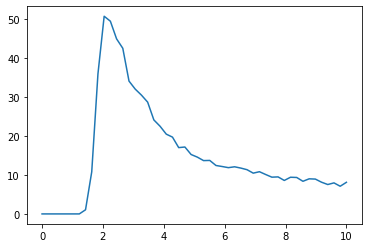

In [83]:
array_of_radii = np.linspace(0,L,no_of_shells)
dist_array = dist_array/(counter*len(dist_array))
plt.plot(array_of_radii, dist_array)

In [ ]:
len(pair_distance_list)

In [ ]:
def create_picture(positions):
    plt.cla()
    plt.gca().set_aspect('equal')
    plt.axis([0, L, 0, L])
    plt.setp(plt.gca(), xticks=[0, L], yticks=[0, L])
    for x,y in positions:
        atom = plt.Circle((x, y), 0.45, fc='r')
        plt.gca().add_patch(atom)
create_picture(pos)

# Radial Distribution

In [ ]:
radial_dis_data = []
pair_distance_data = []
for i in range(len(pos)):
    for j in range(len(pos)):
        if i!= j:
            rij = pos[j]-pos[i]
            pair_distance = np.dot(rij,rij)
            pair_distance_data.append(pair_distance)
            radial_dis_data.append(rdf(pair_distance))

print(radial_dis_data)

In [ ]:
plt.plot(pair_distance_data,radial_dis_data)

In [ ]:
pos, v = evolution_with_thermostate(pos, v)
pos, v = evolution_without_thermostate(pos, v)
data_for_rdf = []
pos, v = evolution_without_thermostate(pos, v)
data_for_rdf.append(rdf(pos))

In [ ]:
radiii = np.linspace(0, L, len(data_for_rdf))

In [ ]:
data_for_rdf